In [1]:
from typing import Tuple

import tensorflow as tf
import numpy as np
from tqdm import tqdm
from dataset import DataIterator
import datetime
from skimage import io
from keras import Model

In [2]:
class GANPIX2PIX:
    def __init__(self) -> None:
        self.out_size = 1

    def downsample(self, filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0.0, 0.02)

        result = tf.keras.Sequential()
        result.add(
            tf.keras.layers.Conv2D(
                filters,
                size,
                strides=2,
                padding="same",
                kernel_initializer=initializer,
                use_bias=False,
            )
        )

        if apply_batchnorm:
            result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

        return result

    def upsample(self, filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0.0, 0.02)

        result = tf.keras.Sequential()
        result.add(
            tf.keras.layers.Conv2DTranspose(
                filters,
                size,
                strides=2,
                padding="same",
                kernel_initializer=initializer,
                use_bias=False,
            )
        )

        result.add(tf.keras.layers.BatchNormalization())

        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

        return result

    def get_generator_model(self):
        inputs = tf.keras.layers.Input(shape=[64, 64, 1])

        down_stack = [
            self.downsample(64, 4, apply_batchnorm=False),
            self.downsample(128, 4),
            self.downsample(256, 4),
            self.downsample(512, 4),
        ]

        up_stack = [
            self.upsample(512, 4, apply_dropout=True),
            self.upsample(256, 4),
            self.upsample(128, 4),
            self.upsample(64, 4),
        ]

        initializer = tf.random_normal_initializer(0.0, 0.02)
        last = tf.keras.layers.Conv2DTranspose(
            self.out_size,
            4,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            activation="tanh",
        )

        x = inputs

        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])

        x = last(x)

        return tf.keras.Model(inputs=inputs, outputs=x)

    def get_discriminator_model(self):
        initializer = tf.random_normal_initializer(0.0, 0.02)

        inp = tf.keras.layers.Input(shape=[64, 64, 1], name="input_mask")
        tar = tf.keras.layers.Input(shape=[64, 64, 1], name="target_image")

        x = tf.keras.layers.concatenate([inp, tar])

        down1 = self.downsample(64, 4, False)(x)
        down2 = self.downsample(128, 4)(down1)
        down3 = self.downsample(256, 4)(down2)

        zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
        conv = tf.keras.layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer, use_bias=False
        )(zero_pad1)

        batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
        leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
        zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

        last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(
            zero_pad2
        )

        return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [3]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(
        disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(
        tf.zeros_like(disc_generated_output), disc_generated_output
    )
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [4]:
from pathlib import Path


pix2pix = GANPIX2PIX()
generator: Model = pix2pix.get_generator_model()
discriminator: Model = pix2pix.get_discriminator_model()

generator.compile()
discriminator.compile()

log_dir="logs/"
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + date)

image_save_path = log_dir + "fit/" + date + '/images/'
model_save_path = log_dir + "fit/" + date + '/generators/'

Path(image_save_path).mkdir(parents=True, exist_ok=True)
Path(model_save_path).mkdir(parents=True, exist_ok=True)
print(image_save_path, model_save_path)


logs/fit/20230317-001441/images/ logs/fit/20230317-001441/generators/


In [5]:
from matplotlib import pyplot as plt


@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator(
            [input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss',
                          gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

def train_loop(
    epochs: int,
    dataset: Tuple[np.ndarray],
    evaluate_data: Tuple[np.ndarray] = None,
    batch_size=128,
    dataset_rot90=False,
):
    for epoch in range(1, epochs + 1):
        # Init iterator
        masks, images = DataIterator(
            dataset,
            inv_values=False,
            rot90=dataset_rot90,
        ).get_dataset()

        masks = np.array(masks, dtype=np.float32)
        images = np.array(images, dtype=np.float32)

        for _step, i in tqdm(enumerate(range(0, len(images) - batch_size + 1, batch_size)), total=len(images) // batch_size):
            x, y = masks[i:i+batch_size], images[i:i+batch_size]
            train_step(x, y, _step * epoch)

        del masks, images
        
        generator.save(model_save_path + f'gan_{epoch}.hdf5')
        
        if evaluate_data is not None:
            xdata, ydata = evaluate_data
            pdata = generator.predict_on_batch(xdata)

            for i in range(len(xdata)):
                x, y, p = xdata[i], ydata[i], pdata[i]
                image = np.array(
                    np.concatenate([x, (p + 1) / 2, (y + 1) / 2.0], axis=1) * 255, "uint8"
                )
                impath = image_save_path + f'{i}.png'
                io.imsave(impath, image)
                if i == 0:
                    plt.imshow(image, 'gray')
                    plt.show()

                

  7%|▋         | 4/60 [00:07<01:25,  1.53s/it]

  8%|▊         | 5/60 [00:08<01:15,  1.37s/it]

100%|██████████| 60/60 [01:09<00:00,  1.15s/it]


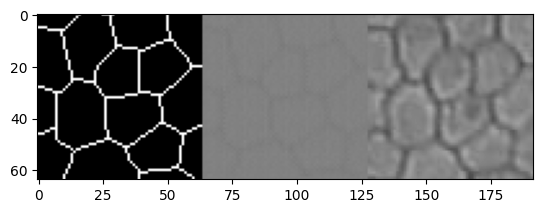

100%|██████████| 60/60 [00:47<00:00,  1.27it/s]


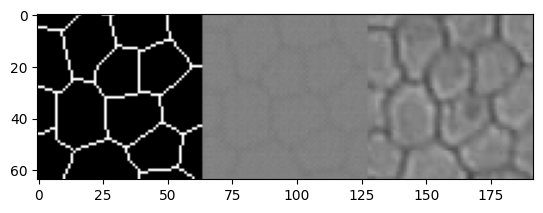

100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


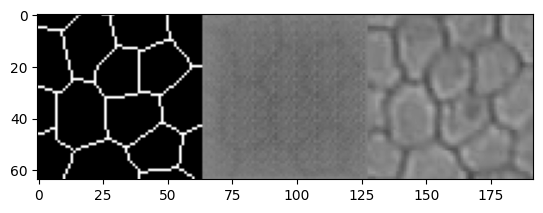

100%|██████████| 60/60 [00:44<00:00,  1.34it/s]


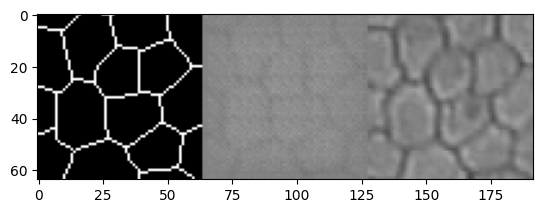

100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


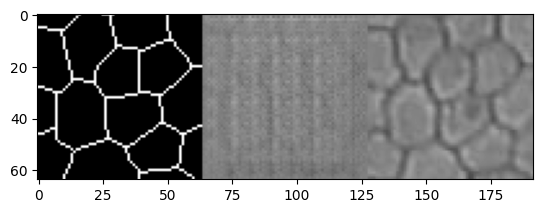

100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


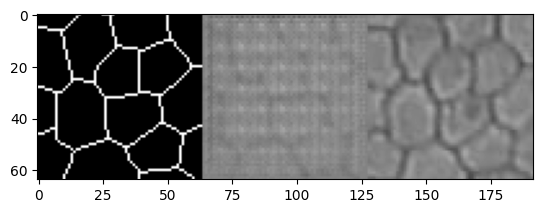

100%|██████████| 60/60 [00:50<00:00,  1.18it/s]


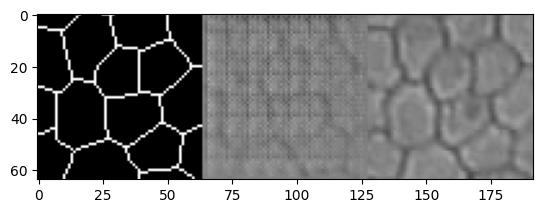

100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


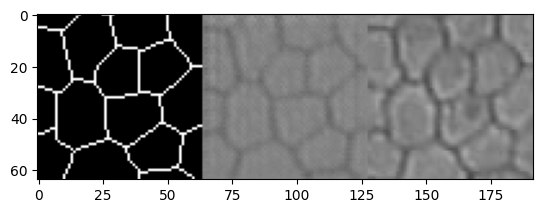

100%|██████████| 60/60 [00:46<00:00,  1.29it/s]


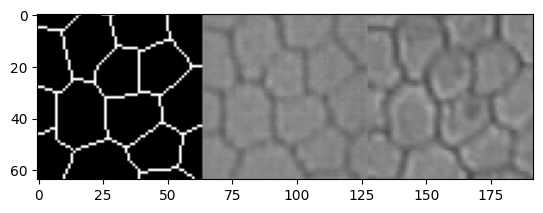

100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


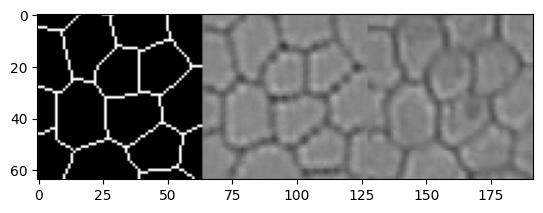

100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


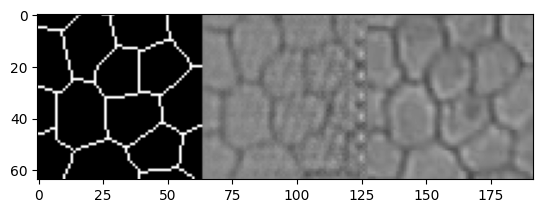

100%|██████████| 60/60 [00:40<00:00,  1.47it/s]


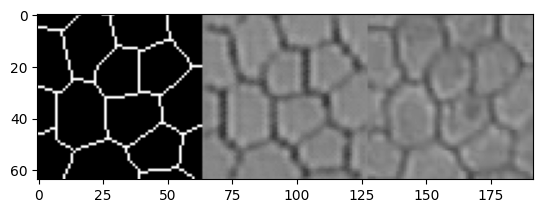

 88%|████████▊ | 53/60 [00:40<00:05,  1.32it/s]


KeyboardInterrupt: 

In [6]:
import json
import os
from dataset import DataIterator, load_dataset
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

with open("config.json") as config_file:
    config = json.load(config_file)['gan.training']

data_path = "./extra_data/Alizarine/folds.json"
train, _ = load_dataset(data_path, True)[0]
validation_data = DataIterator(train, 1, patch_per_image=1, inv_values=False).get_dataset()

train_loop(100, train, validation_data, batch_size=256)